In [1]:
import os

# Preview Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Preprocessing Data

import os
import numpy as np
import cv2

# Model Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Accuracy and Loss
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
picture = 'Data'
classes_picture = os.listdir(picture)
print("Classes in this dataset are:")
for i in classes_picture:
    print(i)





Classes in this dataset are:
Adams
Jeremy
Samuel



Adams
Total Images: 101
Resolution of The Image: (1280, 960, 3)


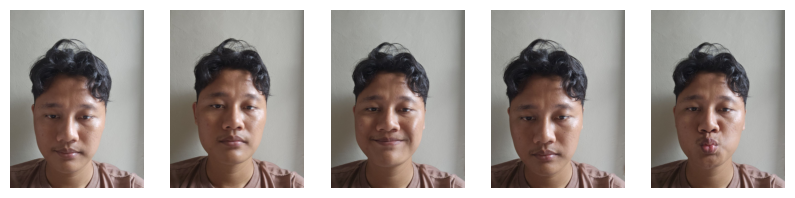


Jeremy
Total Images: 100
Resolution of The Image: (4352, 3264, 3)


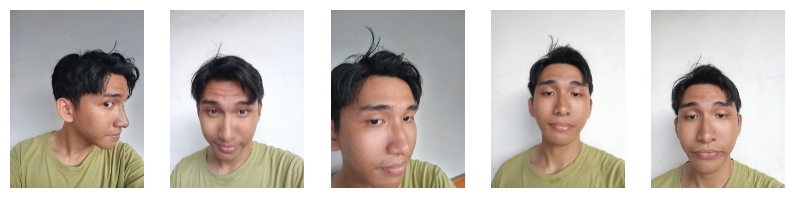


Samuel
Total Images: 101
Resolution of The Image: (4080, 3072, 3)


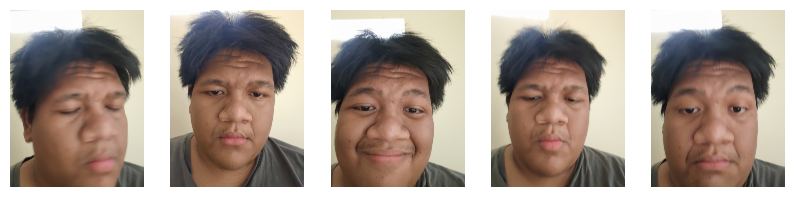

In [3]:
for item in classes_picture:
  print("")
  print(item)
  class_dir = os.path.join(picture, item)
  class_images = os.listdir(class_dir)
  random.shuffle(class_images)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of The Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

Processing Adams...
Processing Jeremy...
Processing Samuel...

Resized data shape: (302, 224, 224, 3)
Labels shape: (302,)


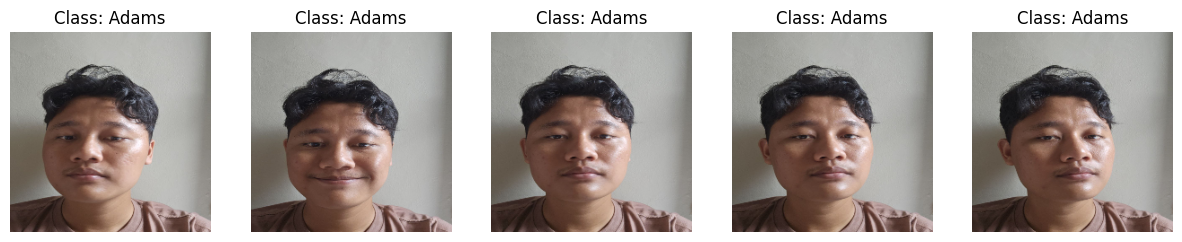

In [4]:
# Define the target size for resizing images
target_size = (224, 224)

# Create lists to store resized images and their labels
X = []  # Images
y = []  # Labels

# Process each class
for class_idx, class_name in enumerate(classes_picture):
    class_dir = os.path.join(picture, class_name)
    class_images = os.listdir(class_dir)
    
    print(f"Processing {class_name}...")
    
    # Process each image in the class
    for img_name in class_images:
        img_path = os.path.join(class_dir, img_name)
        try:
            # Read and resize image
            img = mpimg.imread(img_path)
            img_resized = cv2.resize(img, target_size)
            
            # Append resized image and its label
            X.append(img_resized)
            y.append(class_idx)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print("\nResized data shape:", X.shape)
print("Labels shape:", y.shape)

# Display some resized images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.title(f"Class: {classes_picture[y[i]]}")
    plt.axis('off')
plt.show()


In [40]:
# Split data into train (70%), validation (20%), and test (10%)
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (will be split into val and test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# # Second split: split temp into 20% val and 10% test (20/30 ≈ 0.67 of temp)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33, random_state=42, stratify=y_val)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples") 
# print(f"Test set: {len(X_test)} samples")


Train set: 211 samples
Validation set: 91 samples


In [45]:

# Define data augmentation parameters with maximum aggressive augmentation for extreme variance
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,  
    width_shift_range=0.5,  
    height_shift_range=0.5, 
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.3, 2.0],  
    fill_mode='nearest'  
)

# Create a generator for training data with very small batch size for maximum variance
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=8,  
    shuffle=True  # Ensure shuffling for more randomness
)

# Create a generator for validation data (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=8,
    shuffle=False
)

# # Create a generator for test data (only rescaling, no augmentation)
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow(
#     X_test,
#     y_test,
#     batch_size=8,  
#     shuffle=False
# )


In [60]:
model_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model_base.layers:
    layer.trainable = False


model = tf.keras.Sequential([
    model_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

In [61]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,053,507 (11.65 MB)

 Trainable params: 795,523 (3.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [62]:
# Compile the model with Adam optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Changed from binary_crossentropy
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 932ms/step - accuracy: 0.4030 - loss: 1.3029 - val_accuracy: 0.9780 - val_loss: 0.3792
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.8041 - loss: 0.4956 - val_accuracy: 1.0000 - val_loss: 0.0647
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.9044 - loss: 0.3180 - val_accuracy: 0.9890 - val_loss: 0.0621
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.9693 - loss: 0.1146 - val_accuracy: 0.9890 - val_loss: 0.0618
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.9342 - loss: 0.1952 - val_accuracy: 0.9890 - val_loss: 0.0510
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.9605 - loss: 0.1240 - val_accuracy: 0.9890 - val_loss: 0.0263
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.9933 - loss: 0.0327 - val_accuracy: 0.9890 - val_loss: 0.0252
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.9657 - loss: 0.1066 - val_accuracy: 0

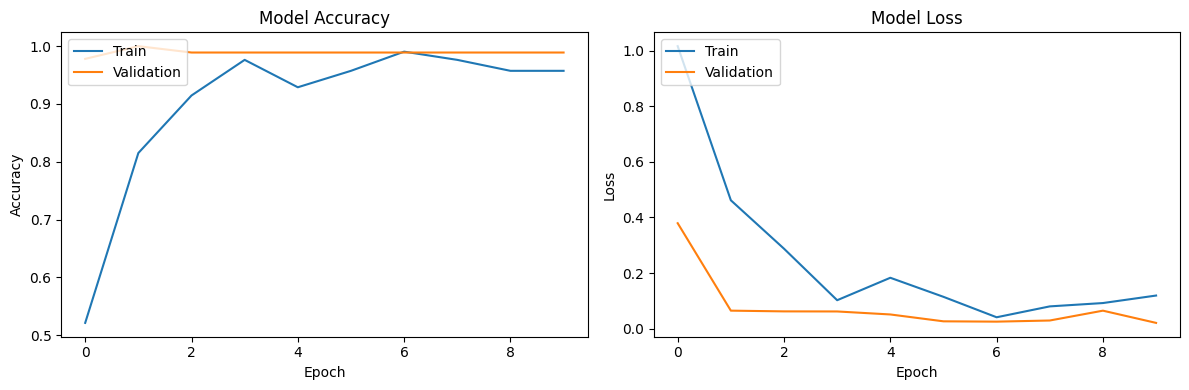

In [63]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [65]:
# Evaluate the model on the test set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes))


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.97      0.98        30
           2       1.00      1.00      1.00        30

    accuracy                           0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91



In [66]:
# Print the final test accuracy
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9965 - loss: 0.0137
Test Accuracy: 0.9890


In [67]:
model.save('model.h5')